In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium

import requests
import json
import time

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
API = "YRAXSVP4LHRKKPBAXORWPYF1I4PTJWXPOBFOURYJXU335BX3"

In [ ]:
def fetch_foursquare_data(lat, lon, radius = 1000, limit = 50,category = None, api_key = API):

  url = "https://places-api.foursquare.com/places/search"

  headers = {
      "accept": "application/json",
      "Authorization": f"Bearer {api_key}",
      "X-Places-Api-Version": "2025-06-17"
  }

  params = {
      "ll": f"{lat},{lon}",
      "radius": radius,
      "limit": limit
  }

  if category:
    params["categories"] = category

  # print("Request URL:", url)
  # print("Request headers:", headers)
  # print("Request params:", params)


  response = requests.get(url, headers=headers, params=params)

  if(response.status_code == 200):
    return response.json()
  else:
    print("Error => ",response.status_code)
    return None

  # print(response.text)

In [ ]:
# Bangalore center lat and long
center_lat = 13.133521
center_long = 77.567135

In [ ]:
# Cleaning to get the required features
def parse_places_response(data):
    places = data.get('results', [])
    cleaned = []

    for place in places:
        cleaned.append({
            'id': place.get('fsq_place_id'),
            'name': place.get('name'),
            'lat': place.get('latitude'),
            'lon': place.get('longitude'),
            'address': place.get('location', {}).get('formatted_address'),
            'categories': [cat['name'] for cat in place.get('categories', [])]
        })

    return pd.DataFrame(cleaned)


In [ ]:
categories_list = ['13199', '18077', '16032', '17069', '13032', '17145', '17114']

category_name_map = {
    '13199': 'indian-restaurants',
    '18077': 'gyms',
    '16032': 'parks',
    '17069': 'groceries',
    '13032': 'cafe',
    '17145': 'pharmacy',
    '17114': 'shopping mall'
}


In [ ]:
# 13.026388, 77.682545
bangalore_data = fetch_foursquare_data(12.9716, 77.5946, category = "17114", api_key = API)

df_bangalore = parse_places_response(bangalore_data)
df_bangalore.head()

,id,name,lat,lon,address,categories
0,51efe570498e01081549f692,Bengaluru Baking Co.,12.971761,77.595128,"JW Marriott Bengaluru (Vittal Mallya Road), Ba...",[Bakery]
1,4b759767f964a520b4162ee3,The Square,12.971671,77.594132,"#23/2, Near UB City (Near UB City), Bangalore ...","[Coffee Shop, Café]"
2,5332e12b11d215ddd88aa74f,JW Marriott Executive Lounge,12.972120,77.594804,,[Lounge]
3,528f734f11d24f6d2c578d31,Spice Terrace,12.972254,77.595200,"JW Mariot, Bangalore, Karnātaka",[Lounge]
4,523de40611d2996a150886fc,J W Kitchen,12.972410,77.594592,"Near U B City (Vittal Mallya Road), Bangalore ...",[Asian Restaurant]


In [ ]:
df_bangalore['categories']

,categories
0,[Bakery]
1,"[Coffee Shop, Café]"
2,[Lounge]
3,[Lounge]
4,[Asian Restaurant]
5,[Shopping Mall]
6,[Italian Restaurant]
7,[French Restaurant]
8,"[Japanese Restaurant, Asian Restaurant, Bar]"
9,"[Lounge, Night Club]"


In [ ]:
for val in df_bangalore['categories']:
  if(val in 'residential'):
     print(val)

TypeError: 'in <string>' requires string as left operand, not list

In [ ]:
df_bangalore.shape

Less Data so using more locations in bangalore (spanning larger radius)

In [ ]:
resi_data = fetch_foursquare_data(
    lat=center_lat,
    lon=center_long,
    radius=10000,   # 10 km around city center
    category="4e67e38e036454776db1fb3a",
    limit=50,       # Max 50 places per call
    api_key=API
)

df_residential = parse_places_response(resi_data)

In [ ]:
df_residential.shape

(50, 6)

In [ ]:
# Getting amenities count for each location in df_residential

amenity_data = []

for idx, row in df_residential.iterrows():
    counts = {}
    lat, lon = row['lat'], row['lon']

    print(f"Processing {idx+1}/{len(df_residential)}: Location at ({lat}, {lon})")

    for cat in categories_list:
        data = fetch_foursquare_data(lat, lon, radius=1000, category=cat, api_key=API)
        counts[category_name_map[cat]] = len(data.get('results', [])) if data else 0
        time.sleep(1)  # Respect API rate limit

    counts['id'] = row['id']  # keep the original location id
    amenity_data.append(counts)

df_amenities = pd.DataFrame(amenity_data)


Processing 1/50: Location at (13.145064719956233, 77.56775466201839)
Processing 2/50: Location at (13.145139688294375, 77.57004945384895)
Processing 3/50: Location at (13.124011189820315, 77.59509883674983)
Processing 4/50: Location at (13.154613, 77.567784)
Processing 5/50: Location at (13.154722213745117, 77.56767272949219)
Processing 6/50: Location at (13.093498229269551, 77.58242890586968)
Processing 7/50: Location at (13.10356050006949, 77.58440897583748)
Processing 8/50: Location at (13.099574459391269, 77.57800916914327)
Processing 9/50: Location at (13.097468, 77.583889)
Processing 10/50: Location at (13.099390491804176, 77.58828222751241)
Processing 11/50: Location at (13.099454, 77.589212)
Processing 12/50: Location at (13.107072600604367, 77.58132124359582)
Processing 13/50: Location at (13.1515804, 77.5429763)
Processing 14/50: Location at (13.099440172081719, 77.58935483292368)
Processing 15/50: Location at (13.17421146196576, 77.59719722600528)
Processing 16/50: Location 

In [ ]:
df_residential_copy = df_residential.copy()
# Merge counts back to original df_residential if you want:
df_residential_copy = df_residential_copy.merge(df_amenities, on='id', how='left')

In [ ]:
df_residential.to_csv('bangalore_residential_places.csv', index=False)
df_residential_copy.to_csv('bangalore_residential_places_amenities.csv', index=False)
print("saved")

saved


In [ ]:
df_residential_copy.head()

,id,name,lat,lon,address,categories,indian-restaurants,gyms,parks,groceries,cafe,pharmacy,shopping mall
0,50b89055498e6c9d5e6867bb,Café Coffee Day,13.145065,77.567755,,"[Coffee Shop, Café]",5,5,5,5,5,5,5
1,50fbb9a1e4b0aa46b66ee7f8,Bhagini Pavilion,13.145140,77.570049,"Singhanayaka Hallu (Doddabalapura Main Road), ...",[Indian Restaurant],6,6,6,6,6,6,6
2,523d2d6e498edcd74f662f6a,Sunburn Arena I AM Hardwell,13.124011,77.595099,"Supernova Convention Centre (Yelhanka), Bangal...",[Arts and Entertainment],6,6,6,6,6,6,6
3,51d5b1a6498ec91fbda4d51f,Café Coffee Day,13.154613,77.567784,Karnātaka,"[Coffee Shop, Café]",6,6,6,6,6,6,6
4,5247a47a11d2b4e2a1590ad1,Café Coffee Day,13.154722,77.567673,"Hotel Saileela Singanayakanahalli (Yelahanka),...","[Coffee Shop, Café]",6,6,6,6,6,6,6


Visualization

In [ ]:
# Average number of each amenity near residential places
df_amenities_only = df_residential_copy[list(category_name_map.values())]
df_amenities_only.mean().sort_values(ascending=False)


,0
indian-restaurants,30.38
gyms,30.38
parks,30.38
groceries,30.38
cafe,30.38
pharmacy,30.38
shopping mall,30.38


In [ ]:
df_amenities_only.head()

,indian-restaurants,gyms,parks,groceries,cafe,pharmacy,shopping mall
0,5,5,5,5,5,5,5
1,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6
4,6,6,6,6,6,6,6


In [ ]:
# To get the location with top amenities
df_amenities_copy = df_residential_copy.copy()

In [ ]:
df_amenities_copy.shape

(50, 13)

In [ ]:
df_amenities_copy['amenity_score'] = df_amenities_only.sum(axis=1)
df_amenities_copy['amenity_score'].unique()

array([ 35,  42, 196, 238, 350, 252, 336, 322, 315,   7, 119, 280, 105,
       224,  56, 133,  98, 259, 287, 126,  49, 343,  91])

In [ ]:
# Top 5 most well-served residential places
top_residential = df_amenities_copy.sort_values(by='amenity_score', ascending=False).head()

In [ ]:
top_residential

,id,name,lat,lon,address,categories,indian-restaurants,gyms,parks,groceries,cafe,pharmacy,shopping mall,amenity_score
7,4cfb9f16dccef04d1c34bc9c,Just Bake,13.099574,77.578009,"Nr Yelahanka Police station, Bangalore, Karnātaka","[Bakery, Snack Place]",50,50,50,50,50,50,50,350
25,50dd764ae4b0d2d23682654c,Big Straw,13.063414,77.591192,"Century Corbel Commercial, Sahakarnagar Main R...","[Bubble Tea Shop, Juice Bar, Pizzeria]",50,50,50,50,50,50,50,350
41,661922ee0937851486bba317,Inox Megaplex,13.070943,77.589660,"Phoenix Mall Of Asia, Bangalore 560092, Karnātaka",[Movie Theater],50,50,50,50,50,50,50,350
45,4bdf373917fdef3b8cbb4e36,Sanjay Dhaba,13.058612,77.593767,"Bellary Rd, Bangalore 560092, Karnātaka",[Indian Restaurant],50,50,50,50,50,50,50,350
43,54cc9d58498eb6d466434829,More Mega Store,13.057881,77.592099,"Sahakaranagar (Kodigehalli main Road), Bangalo...",[Department Store],50,50,50,50,50,50,50,350


##K Means on location Dataset

In [ ]:
# Selecting the features for clustering
features = [col for col in df_amenities.columns if col != 'id']
print(features)

['indian-restaurants', 'gyms', 'parks', 'groceries', 'cafe', 'pharmacy', 'shopping mall']


In [ ]:
X = df_residential_copy[features]
print("Rows, cols = {}".format(X.shape))
X.head()

Rows, cols = (50, 7)


,indian-restaurants,gyms,parks,groceries,cafe,pharmacy,shopping mall
0,5,5,5,5,5,5,5
1,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6
4,6,6,6,6,6,6,6


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

In [ ]:
df_cluster = df_residential_copy.copy()
df_cluster.head()

,id,name,lat,lon,address,categories,indian-restaurants,gyms,parks,groceries,cafe,pharmacy,shopping mall
0,50b89055498e6c9d5e6867bb,Café Coffee Day,13.145065,77.567755,,"[Coffee Shop, Café]",5,5,5,5,5,5,5
1,50fbb9a1e4b0aa46b66ee7f8,Bhagini Pavilion,13.145140,77.570049,"Singhanayaka Hallu (Doddabalapura Main Road), ...",[Indian Restaurant],6,6,6,6,6,6,6
2,523d2d6e498edcd74f662f6a,Sunburn Arena I AM Hardwell,13.124011,77.595099,"Supernova Convention Centre (Yelhanka), Bangal...",[Arts and Entertainment],6,6,6,6,6,6,6
3,51d5b1a6498ec91fbda4d51f,Café Coffee Day,13.154613,77.567784,Karnātaka,"[Coffee Shop, Café]",6,6,6,6,6,6,6
4,5247a47a11d2b4e2a1590ad1,Café Coffee Day,13.154722,77.567673,"Hotel Saileela Singanayakanahalli (Yelahanka),...","[Coffee Shop, Café]",6,6,6,6,6,6,6


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(scaled_data)

In [ ]:
df_cluster['cluster'].unique()

array([1, 0, 2, 3], dtype=int32)

In [ ]:
df_cluster['cluster'].value_counts()

,count
cluster,
2,19
1,13
0,11
3,7


Cluster Summary

In [ ]:
cluster_summary = df_cluster.groupby('cluster')[features].mean()
print(cluster_summary)

         indian-restaurants       gyms      parks  groceries       cafe  \
cluster                                                                   
0                 36.818182  36.818182  36.818182  36.818182  36.818182   
1                  6.076923   6.076923   6.076923   6.076923   6.076923   
2                 48.421053  48.421053  48.421053  48.421053  48.421053   
3                 16.428571  16.428571  16.428571  16.428571  16.428571   

          pharmacy  shopping mall  
cluster                            
0        36.818182      36.818182  
1         6.076923       6.076923  
2        48.421053      48.421053  
3        16.428571      16.428571  


In [ ]:
# Cluster labeling

cluster_rename_map = {
    2: 'Amenity-Rich',
    0: 'Moderately Amenity-Rich',
    3: 'Amenity-Medium',
    1: 'Amenity-Poor'
}

# this copy has cluster labels(named)
df_cluster_copy = df_cluster.copy()

df_cluster_copy['cluster_label'] = df_cluster_copy['cluster'].map(cluster_rename_map)


In [ ]:
df_cluster_copy.head()

,id,name,lat,lon,address,categories,indian-restaurants,gyms,parks,groceries,cafe,pharmacy,shopping mall,cluster,cluster_label
0,50b89055498e6c9d5e6867bb,Café Coffee Day,13.145065,77.567755,,"[Coffee Shop, Café]",5,5,5,5,5,5,5,1,Amenity-Poor
1,50fbb9a1e4b0aa46b66ee7f8,Bhagini Pavilion,13.145140,77.570049,"Singhanayaka Hallu (Doddabalapura Main Road), ...",[Indian Restaurant],6,6,6,6,6,6,6,1,Amenity-Poor
2,523d2d6e498edcd74f662f6a,Sunburn Arena I AM Hardwell,13.124011,77.595099,"Supernova Convention Centre (Yelhanka), Bangal...",[Arts and Entertainment],6,6,6,6,6,6,6,1,Amenity-Poor
3,51d5b1a6498ec91fbda4d51f,Café Coffee Day,13.154613,77.567784,Karnātaka,"[Coffee Shop, Café]",6,6,6,6,6,6,6,1,Amenity-Poor
4,5247a47a11d2b4e2a1590ad1,Café Coffee Day,13.154722,77.567673,"Hotel Saileela Singanayakanahalli (Yelahanka),...","[Coffee Shop, Café]",6,6,6,6,6,6,6,1,Amenity-Poor


In [ ]:
print(df_cluster_copy[df_cluster_copy['cluster_label'] == 'Amenity-Rich'])

                          id                              name        lat  \
7   4cfb9f16dccef04d1c34bc9c                         Just Bake  13.099574   
9   4c5fc61e924b76b0d2e8e7b9                   Café Coffee Day  13.099390   
10  55993ee2498e6d86f2cb3f97                    Baskin-Robbins  13.099454   
11  5028dacbe4b0fe423e5bf26c                   Rolls On Wheels  13.107073   
13  523ee09a498e8f61ad3972dd                            Subway  13.099440   
19  4d25ddf6be99b60cd307fb6e                    Domino's Pizza  13.099618   
22  4ef1016a5c5cfe0cf5c86850                      NES Bus Stop  13.097684   
24  5c02b6d6464d65002ce4c334  Purnabramha Maharashtrian Restra  13.099303   
25  50dd764ae4b0d2d23682654c                         Big Straw  13.063414   
26  582f4eadfb549a1ff5a23b0a                  The Druid Garden  13.063946   
28  4c518ee31c67ef3b8d0e18b9                    9th Mile Dhaba  13.086513   
33  4e9576237ee6617723634f12                         Swensen's  13.063476   

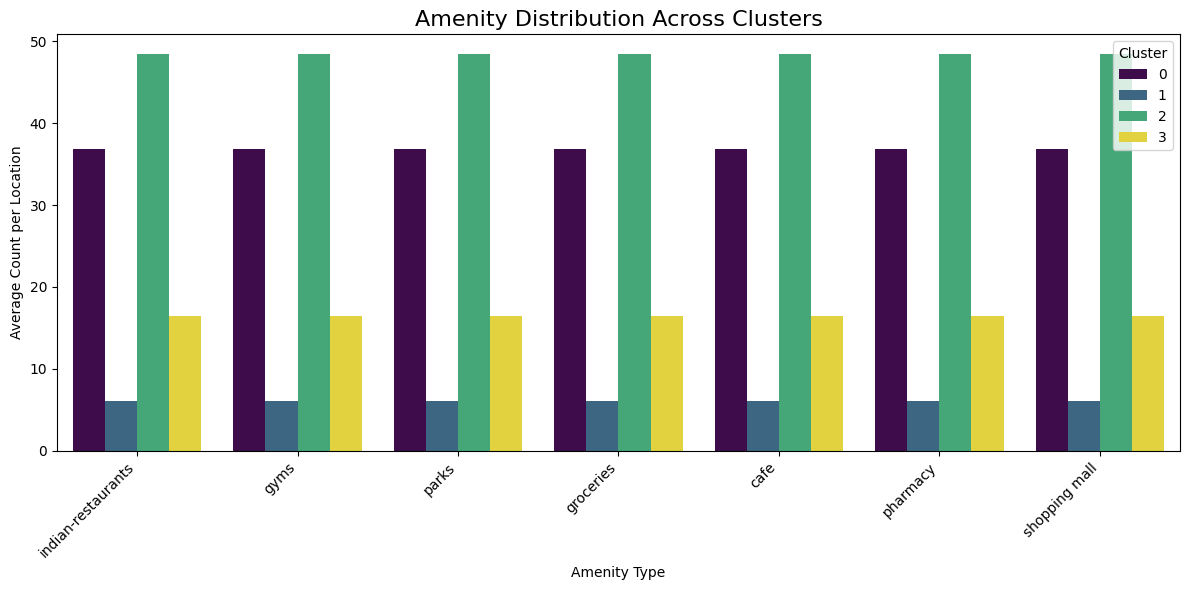

In [ ]:
cluster_summary2 = cluster_summary.copy()
cluster_summary2 = cluster_summary2.reset_index()

plt.figure(figsize=(12, 6))
df_melted = cluster_summary2.melt(id_vars="cluster", var_name="Amenity", value_name="Count")

sns.barplot(data=df_melted, x="Amenity", y="Count", hue="cluster", palette="viridis")

plt.title("Amenity Distribution Across Clusters", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Count per Location")
plt.xlabel("Amenity Type")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


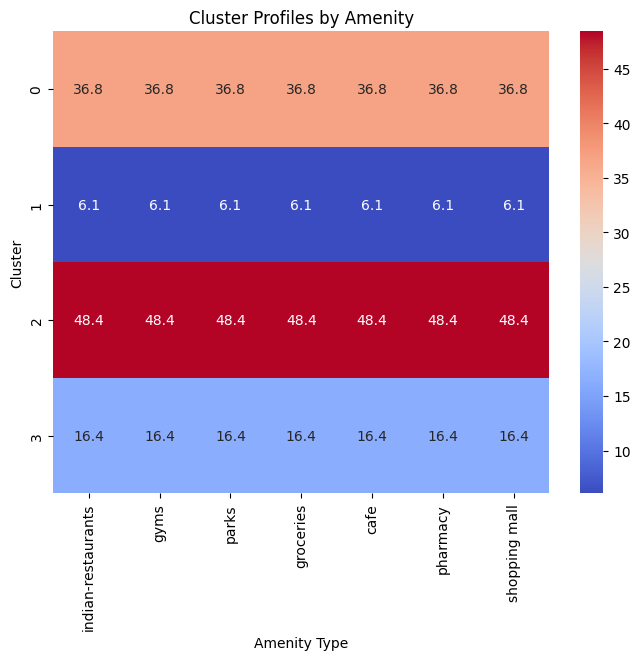

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cluster_summary, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Cluster Profiles by Amenity")
plt.ylabel("Cluster")
plt.xlabel("Amenity Type")
plt.show()


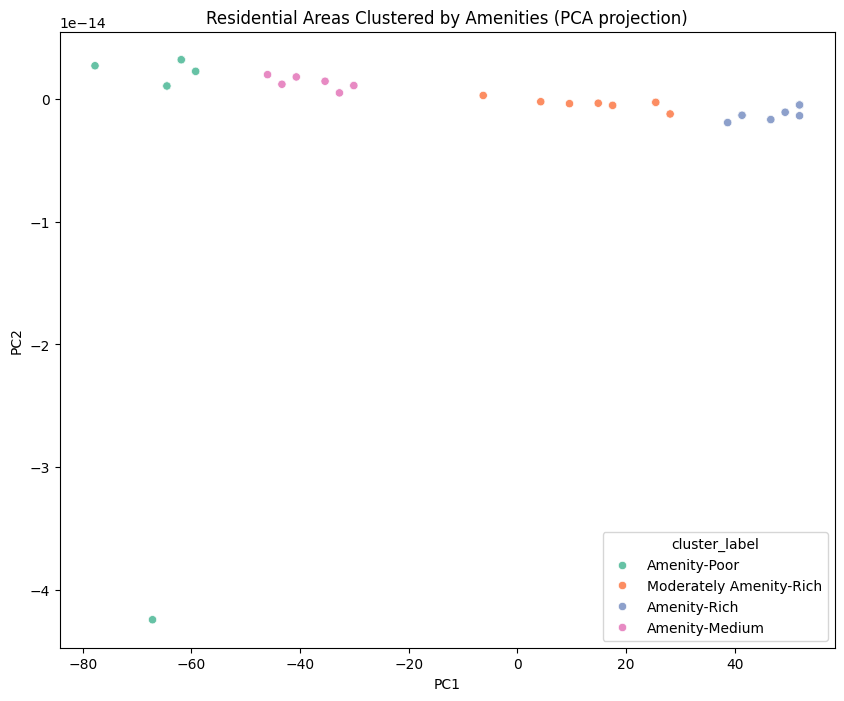

In [ ]:
# Visualize with PCA(2D)

df_cluster_pca = df_cluster_copy.copy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_cluster_pca['PC1'] = X_pca[:,0]
df_cluster_pca['PC2'] = X_pca[:,1]

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_cluster_pca, x='PC1', y='PC2', hue='cluster_label', palette='Set2')
plt.title("Residential Areas Clustered by Amenities (PCA projection)")
plt.show()


## Plotting on Map using Folium

In [ ]:
m = folium.Map(location=[center_lat, center_long], zoom_start=12)

In [ ]:
m = folium.Map(location=[df_cluster_copy['lat'].mean(), df_cluster['lon'].mean()], zoom_start=13)

colors = ["red", "blue", "green", "purple"]  # adjust if >4 clusters

for _, row in df_cluster_copy.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"{row['name']} - {row['cluster_label']}",
        color=colors[row['cluster']],
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m.save("clusters_map.html")


In [ ]:
m

In [ ]:
df_residential_copy['categories'].head()

NameError: name 'df_residential_copy' is not defined

In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create a base map centered on your study area
map_clusters = folium.Map(location=[df_cluster_copy['lat'].mean(), df_cluster['lon'].mean()], zoom_start=13)

# Generate a color palette for clusters
num_clusters = df_cluster['cluster'].nunique()
colormap = cm.get_cmap('Set1', num_clusters)   # Set1 is clean & distinct

# Normalize values (0 → n_clusters-1)
norm = colors.Normalize(vmin=0, vmax=num_clusters-1)

# Add markers
for _, row in df_cluster.iterrows():
    cluster_id = row['cluster']
    color = colors.to_hex(colormap(norm(cluster_id)))
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        popup=f"Cluster {cluster_id}, Name: {row.get('name', 'N/A')}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(map_clusters)

# Save to HTML
map_clusters.save("clusters_map_colored.html")


/tmp/ipython-input-1266688828.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set1', num_clusters)   # Set1 is clean & distinct


In [ ]:
m

Detailed

In [ ]:
df_cluster_copy.head()

,id,name,lat,lon,address,categories,indian-restaurants,gyms,parks,groceries,cafe,pharmacy,shopping mall,cluster,cluster_label
0,50b89055498e6c9d5e6867bb,Café Coffee Day,13.145065,77.567755,,"[Coffee Shop, Café]",5,5,5,5,5,5,5,1,Amenity-Poor
1,50fbb9a1e4b0aa46b66ee7f8,Bhagini Pavilion,13.145140,77.570049,"Singhanayaka Hallu (Doddabalapura Main Road), ...",[Indian Restaurant],6,6,6,6,6,6,6,1,Amenity-Poor
2,523d2d6e498edcd74f662f6a,Sunburn Arena I AM Hardwell,13.124011,77.595099,"Supernova Convention Centre (Yelhanka), Bangal...",[Arts and Entertainment],6,6,6,6,6,6,6,1,Amenity-Poor
3,51d5b1a6498ec91fbda4d51f,Café Coffee Day,13.154613,77.567784,Karnātaka,"[Coffee Shop, Café]",6,6,6,6,6,6,6,1,Amenity-Poor
4,5247a47a11d2b4e2a1590ad1,Café Coffee Day,13.154722,77.567673,"Hotel Saileela Singanayakanahalli (Yelahanka),...","[Coffee Shop, Café]",6,6,6,6,6,6,6,1,Amenity-Poor


In [ ]:
# 1) Make sure required columns exist
required_cols = ['lat', 'lon', 'name', 'cluster', 'cluster_label']
missing = [c for c in required_cols if c not in df_cluster_copy.columns]
if missing:
    raise ValueError(f"Your df_cluster is missing these columns: {missing}")

# 2) Amenity columns you counted during Task 4
candidate_amenities = [
    'indian-restaurants', 'gyms', 'parks', 'groceries',
    'cafe', 'pharmacy', 'shopping mall'  # note the space in this name
]
amenity_cols = [c for c in candidate_amenities if c in df_cluster.columns]
if not amenity_cols:
    raise ValueError("No amenity columns found. Please check your column names.")

df_cluster_amenity = df_cluster_copy.copy()
# 3) Create a total-amenities column for variable marker size (nice visual cue)
df_cluster_amenity['amenity_total'] = df_cluster_copy[amenity_cols].sum(axis=1)


# List of columns that are not amenity counts
non_amenity_cols = ['name', 'amenity_total', 'lat', 'lon', 'cluster', 'cluster_name']

# Keep only numeric columns (i.e., actual amenity counts)
amenity_cols = [
    col for col in df_cluster_amenity.columns
    if col not in non_amenity_cols and pd.api.types.is_numeric_dtype(df_cluster_amenity[col])
]



In [ ]:
# Unique cluster ids (sorted for stable coloring)
unique_clusters = sorted(df_cluster['cluster'].unique())

# A distinct qualitative palette (repeat if more clusters than colors)
palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3',
           '#ff7f00','#a65628','#f781bf','#999999']
color_map = {c: palette[i % len(palette)] for i, c in enumerate(unique_clusters)}


In [ ]:
# Center map at the mean lat/lon of your points
center_lat = float(df_cluster['lat'].mean())
center_lon = float(df_cluster['lon'].mean())

# Clean, light base tiles; control_scale shows a scale bar
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=13,
    tiles='CartoDB Positron',
    control_scale=True
)


In [ ]:
from folium.plugins import MarkerCluster

# Create marker cluster layer
marker_layer = MarkerCluster(name='Residential locations').add_to(m)

# Pre-compute scaling bounds for marker radius
min_tot = float(df_cluster_amenity['amenity_total'].min())
max_tot = float(df_cluster_amenity['amenity_total'].max())
has_variation = max_tot > min_tot

# Columns with amenities (exclude metadata)
amenity_cols = [col for col in df_cluster_amenity.columns if col not in ['name', 'amenity_total', 'lat', 'lon', 'cluster', 'cluster_label']]

for _, row in df_cluster_amenity.iterrows():
    color = color_map[row['cluster']]

    radius = float(np.interp(row['amenity_total'], (min_tot, max_tot), (4, 10))) if has_variation else 6.0

    tooltip_txt = f"{row['name']} • {row['cluster_label']}"

    def get_numeric_value(val):
        try:
            numeric = pd.to_numeric(val, errors='coerce')
            if pd.notnull(numeric) and np.isscalar(numeric):
                return int(numeric)
            else:
                return 'N/A'
        except:
            return 'N/A'

    amenity_lines = "<br>".join([
        f"{col}: {get_numeric_value(row[col])}"
        for col in amenity_cols
    ])

    popup_html = f"""
    <div style="font-size:13px;">
      <b>{row['name']}</b><br>
      <i>{row['cluster_label']} (#{row['cluster']})</i><br><br>
      <b>Amenities nearby</b><br>
      {amenity_lines}
    </div>
    """

    folium.CircleMarker(
        location=[float(row['lat']), float(row['lon'])],
        radius=radius,
        color=color,
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=tooltip_txt,
        popup=folium.Popup(popup_html, max_width=320)
    ).add_to(marker_layer)

# Optional: add layer control if you have multiple layers
folium.LayerControl().add_to(m)

# Save the map
m.save("bangalore_clusters_map.html")


/tmp/ipython-input-1733720936.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.notnull(numeric) and np.isscalar(numeric):


TypeError: macro 'html' takes not more than 0 argument(s)

In [ ]:
# from branca.element import Template, MacroElement
# legend_html = """
# {% macro legend_html() %}
# <div style="
#     position: fixed;
#     bottom: 40px; left: 40px; z-index: 9999;
#     background: white; padding: 10px 12px; border: 2px solid #444;
#     border-radius: 8px; box-shadow: 0 1px 4px rgba(0,0,0,0.2);
#     font-size: 13px; line-height: 1.2;">
#   <div style="font-weight:700; margin-bottom:8px;">Clusters</div>
#   """ + "".join(legend_rows) + """
# </div>
# {% endmacro %}

# {% macro html(this) %}
#     {{ legend_html() }}
# {% endmacro %}
# """
# from branca.element import Template, MacroElement

# legend = MacroElement()
# legend._template = Template(legend_html)
# m.get_root().add_child(legend)

# # Save map
# m.save("bangalore_clusters_map.html")


In [ ]:
# Save to an HTML file (good for sharing)
m.save("bangalore_clusters_map.html")


TypeError: macro 'html' takes not more than 0 argument(s)

#Map with popups

In [ ]:
import folium
from folium.plugins import MarkerCluster
import numpy as np
import pandas as pd

# Create a new map object centered on some coordinates
m = folium.Map(location=[12.97, 77.59], zoom_start=12)  # example for Bangalore

# Create MarkerCluster layer
marker_layer = MarkerCluster(name='Residential locations').add_to(m)

min_tot = float(df_cluster_amenity['amenity_total'].min())
max_tot = float(df_cluster_amenity['amenity_total'].max())
has_variation = max_tot > min_tot

amenity_cols = [col for col in df_cluster_amenity.columns if col not in ['name', 'amenity_total', 'lat', 'lon', 'cluster', 'cluster_label']]

def get_numeric_value(val):
    try:
        numeric = pd.to_numeric(val, errors='coerce')
        if pd.notnull(numeric) and (np.isscalar(numeric) or numeric.size == 1):
            return int(numeric)
        else:
            return 'N/A'
    except:
        return 'N/A'

for _, row in df_cluster_amenity.iterrows():
    color = color_map[row['cluster']]
    radius = float(np.interp(row['amenity_total'], (min_tot, max_tot), (4, 10))) if has_variation else 6.0
    tooltip_txt = f"{row['name']} • {row['cluster_label']}"
    amenity_lines = "<br>".join([
        f"{col}: {get_numeric_value(row[col])}"
        for col in amenity_cols
    ])

    popup_html = f"""
    <div style="font-size:13px;">
      <b>{row['name']}</b><br>
      <i>{row['cluster_label']} (#{row['cluster']})</i><br><br>
      <b>Amenities nearby</b><br>
      {amenity_lines}
    </div>
    """

    folium.CircleMarker(
        location=[float(row['lat']), float(row['lon'])],
        radius=radius,
        color=color,
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=tooltip_txt,
        popup=folium.Popup(popup_html, max_width=320)
    ).add_to(marker_layer)

# Add LayerControl (optional)
folium.LayerControl().add_to(m)

# Save the map — should work now without errors
m.save("bangalore_clusters_map.html")


/tmp/ipython-input-700211637.py:21: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.notnull(numeric) and (np.isscalar(numeric) or numeric.size == 1):


In [ ]:
m

In [ ]:
# Fixing some markers pointing to cafe and stuff

# Filter only residential-type places
df_res_only = df_residential_copy[df_residential_copy['categories'].apply(lambda x: 'Residential' in str(x))]

# Pick a center point (mean of coordinates)
center_lat = df_res_only['lat'].mean()
center_lon = df_res_only['lon'].mean()

# Create map
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Add residential markers colored by cluster
colors = ['red', 'blue', 'green', 'purple', 'orange']
for _, row in df_res_only.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"Residential: {row['name']}<br>Cluster: {row['cluster_name']}",
        icon=folium.Icon(color=colors[int(row['cluster']) % len(colors)])
    ).add_to(m)

# Save to file
m.save("clusters_residential_only.html")


NameError: name 'df_residential_copy' is not defined

In [ ]:
m